In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.spatial import distance_matrix
from matplotlib import cm
from scipy.interpolate import griddata
import copy

# fixed definitions used in functions below 
# General parameters
alat = 2.46 # Used when drawing bands
thop = -2.7 # In-plane hopping term
sigma = 0.48 # For hopping terms
acc = 1.0/np.sqrt(3) # Carbon-carbon (e.g. nearest neighbour) distance
dd1 = acc * alat + 0.4 # In-plane distance cut-off for hopping terms
d = 3.35 # Interlayer distance


# 4 atom unit cell (units of alat)
four_atom_y = np.array([0, 1/(2*np.sqrt(3)), np.sqrt(3)/2, 2/np.sqrt(3) ])
four_atom_y = four_atom_y + 1/(2*np.sqrt(3)) # shift gives symm around y=0 --> easier placement of perfect AA, etc.
four_atom_x = np.array([0.5, 0, 0, 0.5])
sub_cell = np.array([1, -1, 1, -1] )

# unit vectors
shifty = np.sqrt(3)
shiftx = 1.0

# shifts for different stacking options
ABy = 1/(2*np.sqrt(3))
ABx = 0.5
ABya = 1/(np.sqrt(3))
ABxa = 0.0
intya = 1.5*acc #(np.sqrt(3))/2
intxa = 0.0

AAy =0.0
AAx=0.0

#two-atom cell unit vectors
a1 = np.array([1/2, np.sqrt(3)/2, 0])
a2 = np.array([-1/2, np.sqrt(3)/2, 0])
a3 = np.array([0, 0, 0])

unit_vecs = np.array([a1, a2, a3])
cell1_2atom = np.array([[0,0,0], [0,-acc,0]])
cell2_2atom = np.array([[0,0,d/alat], [0,-acc,d/alat]])

cell_order = 1
cells1 = [[0,0,0]]
for index in np.arange(-cell_order, cell_order+1):
    for index2 in np.arange(-cell_order, cell_order+1):
        if ((index!=0) or (index2!=0)):
            cells1.append([index, index2, 0])
cells1 = np.array(cells1)

KK = [2*np.pi/(3*alat), 2*np.pi/(np.sqrt(3)*alat)]



def t_general2(vector, vp0, vs0, cutoff):
    r = np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)
    r1 = np.sqrt(vector[0]**2 + vector[1]**2)
    if r1 <= cutoff:
        r0 = 0.184*2.46
        vp = vp0*np.exp(-(r-1.42)/r0)
        vs = vs0*np.exp(-(r-3.35)/r0)
        hop = vp*(1-(vector[2]/r)**2) + vs*(vector[2]/r)**2 +0j
    else:
        hop = 0
    return hop

def t_general_vec2(xyc, zc, vp0, vs0, cutoff):
    r1 = distance_matrix(xyc, xyc)
    dz = zc - zc[:, np.newaxis]
    r = np.sqrt(r1**2 + dz**2)
    hop=np.zeros_like(r)
    r0 = 0.184*2.46
    vp = vp0*np.exp(-(r-1.42)/r0)
    vs = vs0*np.exp(-(r-3.35)/r0)
    indices = (r1 <= cutoff) & (r !=0)
    hop[indices] = vp[indices]*(1-(dz[indices]/r[indices])**2) + vs[indices]*(dz[indices]/r[indices])**2
    return hop

#this version for multiple cells
def t_general_vec3(xyc, xyc2, zc, zc2, vp0, vs0, cutoff):
    r1 = distance_matrix(xyc, xyc2)
    dz = zc - zc2[:, np.newaxis]
    r = np.sqrt(r1**2 + dz**2)
    hop=np.zeros_like(r)
    r0 = 0.184*2.46
    vp = vp0*np.exp(-(r-1.42)/r0)
    vs = vs0*np.exp(-(r-3.35)/r0)
    indices = (r1 <= cutoff) & (r !=0)
    hop[indices] = vp[indices]*(1-(dz[indices]/r[indices])**2) + vs[indices]*(dz[indices]/r[indices])**2
    return hop

def lorentzian(x,position,width):
    arg = (x-position)/(width/2)
    return (2 / (np.pi *width)) / (1+arg**2)

def get_dos(evals, erange=np.linspace(-3, 3, 501), b=0.1):
    er, ev = np.meshgrid(erange, evals)
    dosc = lorentzian(er, ev, b)
    dos = dosc.sum(axis=0) / len(evals)
   
    return dos

#makes a map of the local stacking
# assumes strict A B A B ordering in the layers
# the coords lists here ONLY have x and y coordinates
def map_stacking (coords1, coords2, pts):
    
    #create inplane distance matrix between sites in the two layers
    d12 = distance_matrix(coords1, coords2)
    
    #indices of all the A atoms in layer 1
    Ainds= np.arange(0, len(coords1), 2)
    
    #indices of all the B atoms in layer 1
    Binds= np.arange(1, len(coords1), 2)
    
    
    #arrays to store the nearest distances at each point
    AAmin, ABmin =[], []
    BAmin, BBmin =[], []
    
    
    #for each A atom in layer 1, find
    #the in-plane distance to the nearest A atom in layer 2
    # and the in-plane distance to the nearest B atom in layer 2
    for A in Ainds:
        AAmin.append(d12[A, 0::2].min())
        ABmin.append(d12[A, 1::2].min())

        
    #for each B atom in layer 1, find
    #the in-plane distance to the nearest A atom in layer 2
    # and the in-plane distance to the nearest B atom in layer 2
    for B in Binds:
        BAmin.append(d12[B, 0::2].min())
        BBmin.append(d12[B, 1::2].min())
        
    # renormalisation -- sets acc = 1 -- I think
    # (all the values for AAmin, ABmin etc. for  AB/BA/AA stackings will be 0 or 1)
    
    # this way, e.g. for AB stacking:  (A in layer 1 above B in layer 2)
    # AAmin = 1
    # ABmin = 0
    # BAmin = 1
    # BBmin = 1    
    
    AAmin = np.array(AAmin)*np.sqrt(3)
    ABmin = np.array(ABmin)*np.sqrt(3)
    BAmin = np.array(BAmin)*np.sqrt(3)
    BBmin = np.array(BBmin)*np.sqrt(3)
    
    
    # extrapolate onto a rectangular grid for easy plotting using maps
    xgrid = np.linspace(coords1[:,0].min(), coords1[:,0].max(), 101)
    ygrid = np.linspace(coords1[:,1].min(), coords1[:,1].max(), 101)

    xgrid, ygrid = np.meshgrid(xgrid, ygrid)

    AAg = griddata( (coords1[::2,0], coords1[::2,1]) , AAmin, (xgrid, ygrid), method='linear')
    ABg = griddata( (coords1[::2,0], coords1[::2,1]) , ABmin, (xgrid, ygrid), method='linear')
    BAg = griddata( (coords1[::2,0], coords1[::2,1]) , BAmin, (xgrid, ygrid), method='linear')
    BBg = griddata( (coords1[::2,0], coords1[::2,1]) , BBmin, (xgrid, ygrid), method='linear')

    
    # function to determine stacking.
    # top line is most important: 
    # BAmin - ABmin = 1 for AB stacking, -1 for BA stacking
    
    stacking = (BAg - ABg)*(AAg + BBg)/2
    
    return xgrid, ygrid, stacking


# generate a BLG unit cell with uniform heterostrain of strength M/N in layer L1, with L2 unstrained
# L1 contains N strained cells, L2 contains N+M unstrained cells
def genBLG_uniform_hs (M, N, L1_xcells, L2_xcells, delx=AAx, dely=AAy):
    L1_ycells = N
    L2_ycells = N + M
    
    strainy = M/N
    strainx= 0.0
    
    # L2 coords: (units of alat)
    layer2x = np.array([])
    layer2y = np.array([])
    layer2s=  np.array([])

    for i in np.arange(L2_xcells):
        for j in np.arange(L2_ycells):
            layer2x = np.concatenate((layer2x, four_atom_x + i*shiftx))
            layer2y = np.concatenate((layer2y, four_atom_y + j*shifty ) ) 
            layer2s = np.concatenate((layer2s, sub_cell))
            
            
    # L1 coords: (units of alat)
    layer1x = np.array([])
    layer1y = np.array([])
    layer1s=  np.array([])


    for i in np.arange(L1_xcells):
        for j in np.arange(L1_ycells):
            layer1x = np.concatenate((layer1x, four_atom_x + i*shiftx))
    #         layer2y = np.concatenate((layer2y, four_atom_y + j*shifty -int((ycells2)/2)*shifty )  )
            layer1y = np.concatenate((layer1y, four_atom_y + j*shifty  )  )

            layer1s = np.concatenate((layer1s, sub_cell))

    layer1y = dely + layer1y*(1.0+strainy)
    layer1x = delx + layer1x*(1.0+strainx)
    
    
    # useful indices:
    layer_all = np.concatenate( ( np.ones_like(layer1s) , 2*np.ones_like(layer2s)))
    sub_all = np.concatenate ((layer1s, layer2s))
    
    #indices for layers and sublattices
    L1 = np.where(layer_all ==1 )[0]
    L2 = np.where(layer_all == 2)[0]

    SA = np.where(sub_all == 1)[0]
    SB = np.where(sub_all == -1)[0]

    L1SA = np.where( (layer_all ==1) & (sub_all == 1) )[0]
    L1SB = np.where( (layer_all ==1) & (sub_all == -1) )[0]
    L2SA = np.where( (layer_all ==2) & (sub_all == 1) )[0]
    L2SB = np.where( (layer_all ==2) & (sub_all == -1) )[0]
    
    return np.array((layer1x, layer1y)).T, np.array((layer2x, layer2y)).T, (L1SA, L1SB, L2SA, L2SB)


# a sigmoid function (smoothness in terms of length L0)
def gen_sig2(x, L0, x0):
    return 1 / ( 1 + np.exp(-(x-x0)/L0) ) 


# multiple sigmoids, can be used to replace an even (linear) distribution of strain
# whilst maintaining the overall strain over a unit cell (in 1D)
# here half the magnitude of the first sigmoid is subtracted: this assumes it is placed at 0
def bunch_sigs2 (x, xs, mags, L0s ):
    a = mags[0] * (gen_sig2(x, L0s[0], xs[0]))
    
    lxs = len(xs)
    
    for i in np.arange(1, lxs):
        a += mags[i] * gen_sig2(x, L0s[i], xs[i])
        
    a -= mags[0]/2
        
    return a


# generate a BLG unit cell with heterostrain of strength M/N in layer L1, with L2 unstrained
# L1 contains N strained cells, L2 contains N+M unstrained cells
# the strain in L1 is non-uniform, and uses sigmoids at the AA and SP interfaces to modify sharpness
def genBLG_relaxed_hs_L1 (M, N, L1_xcells, L2_xcells, delx=AAx, dely=AAy, alpha=3):
    L1_ycells = N
    L2_ycells = N + M
    strainy = M/N
    strainx= 0.0
    
    # L2 coords: (units of alat)
    layer2x = np.array([])
    layer2y = np.array([])
    layer2s=  np.array([])

    for i in np.arange(L2_xcells):
        for j in np.arange(L2_ycells):
            layer2x = np.concatenate((layer2x, four_atom_x + i*shiftx))
            layer2y = np.concatenate((layer2y, four_atom_y + j*shifty ) ) 
            layer2s = np.concatenate((layer2s, sub_cell))
            
            
    # L1 coords: (units of alat)
    layer1x = np.array([])
    layer1y = np.array([])
    layer1s=  np.array([])
    for i in np.arange(L1_xcells):
        for j in np.arange(L1_ycells):
            layer1x = np.concatenate((layer1x, four_atom_x + i*shiftx))
            layer1y = np.concatenate((layer1y, four_atom_y + j*shifty  )  )
            layer1s = np.concatenate((layer1s, sub_cell))

    #layer1y = dely + layer1y*(1.0+strainy)
    layer1y = dely + layer1y + bunch_sigs2(layer1y, 
                         [0, shifty*L1_ycells/2, shifty*L1_ycells], 
                         [2*acc, acc , 2*acc], 
                         [2*acc*alpha, acc*alpha , 2*acc*alpha] ) 
    
    layer1x = delx + layer1x*(1.0+strainx)
    # useful indices:
    layer_all = np.concatenate( ( np.ones_like(layer1s) , 2*np.ones_like(layer2s)))
    sub_all = np.concatenate ((layer1s, layer2s))
    #indices for layers and sublattices
    L1 = np.where(layer_all ==1 )[0]
    L2 = np.where(layer_all == 2)[0]
    SA = np.where(sub_all == 1)[0]
    SB = np.where(sub_all == -1)[0]
    L1SA = np.where( (layer_all ==1) & (sub_all == 1) )[0]
    L1SB = np.where( (layer_all ==1) & (sub_all == -1) )[0]
    L2SA = np.where( (layer_all ==2) & (sub_all == 1) )[0]
    L2SB = np.where( (layer_all ==2) & (sub_all == -1) )[0]
    return np.array((layer1x, layer1y)).T, np.array((layer2x, layer2y)).T, (L1SA, L1SB, L2SA, L2SB)

def plot_strucs (coords_L1, coords_L2, figsize=(6, 15)):
    tree = cKDTree( coords_L1  )
    npairs1 = list(tree.query_pairs(  acc*1.3 ) )
    tree = cKDTree( coords_L2  )
    npairs2 = list(tree.query_pairs(  acc* 1.3 ) )
    fig, ax = plt.subplots(1,1, figsize=figsize)
    for i in npairs1:
        ax.plot( (coords_L1[i[0]][0], coords_L1[i[1]][0]), (coords_L1[i[0]][1], coords_L1[i[1]][1]), 'k', alpha=0.2)
    for i in npairs2:
            ax.plot( (coords_L2[i[0]][0], coords_L2[i[1]][0]), (coords_L2[i[0]][1], coords_L2[i[1]][1]), 'k', alpha=0.2)
    ax.set_aspect('equal')
    xgrid, ygrid, stacking = map_stacking(coords_L1, coords_L2, 101)
    ax.pcolormesh(xgrid, ygrid, stacking, shading='auto', cmap=cm.seismic, vmin=-1, vmax=1)
    return fig, ax
    

# slow --try vectorising this later    (4 atom unit cell version!)
def BLG_bands (kxin, kyin, delx, dely, delta, cells1=cells1):
    in_shape = kxin.shape
    out_shape = list(in_shape)
    out_shape.append(4)
    kx = kxin.flatten()
    ky = kyin.flatten()
    subA1 = (cell1_2atom[0] + cells1.dot(unit_vecs)) * alat
    subB1 = (cell1_2atom[1] + cells1.dot(unit_vecs)) * alat
    subA2 = (cell2_2atom[0] + cells1.dot(unit_vecs) + np.array([delx, dely, 0])) * alat
    subB2 = (cell2_2atom[1] + cells1.dot(unit_vecs) + np.array([delx, dely, 0])) * alat
    # array to store eigenenergies for each k
    evs_3d = []
    for kxa, kya in zip(kx, ky):
        # empty hamiltonian matrix (size of unit cell)
        htemp = np.zeros((4,4), dtype = complex)
        # loop over all possible "neighbour" cells and add hamiltonian contributions 
        # note this includes the "home" cell, where the phase is equal to 1
        for i, cell in enumerate(cells1):
            # real space hopping
            real_hop1 = t_general2(subA1[i]-subB1[0], thop, sigma, dd1)
            # This is the vector to the current cell in cartesian coords
            vec = (cells1[i]).dot(unit_vecs)*alat
            # matrix element = hopping * phase
            fsimple1 = real_hop1 * np.exp(1j * np.dot( vec[0:2], np.array((kxa,kya))))
            # Hamiltonian contribution from this cell
            htemp[0, 1] += fsimple1
            htemp[1, 0] += np.conj(fsimple1)
            real_hop2 = t_general2(subA2[i]-subB2[0], thop, sigma, dd1)
            fsimple2 = real_hop2 * np.exp(1j * np.dot( vec[0:2], np.array((kxa,kya))))
            # Hamiltonian contribution from this cell
            htemp[2, 3] += fsimple2
            htemp[3, 2] += np.conj(fsimple2)
            real_hop3 = t_general2(subA1[0]-subA2[i], thop, sigma, dd1)
            real_hop4 = t_general2(subB1[0]-subB2[i], thop, sigma, dd1)
            real_hop5 = t_general2(subA1[0]-subB2[i], thop, sigma, dd1)
            real_hop6 = t_general2(subB1[0]-subA2[i], thop, sigma, dd1)
            # matrix element = hopping * phase
            fsimple3 = real_hop3 * np.exp(1j * np.dot(vec[0:2], np.array((kxa,kya))))
            fsimple4 = real_hop4 * np.exp(1j * np.dot(vec[0:2], np.array((kxa,kya))))
            fsimple5 = real_hop5 * np.exp(1j * np.dot(vec[0:2], np.array((kxa,kya))))
            fsimple6 = real_hop6 * np.exp(1j * np.dot(vec[0:2], np.array((kxa,kya))))
            # Hamiltonian contribution from this cell
            htemp[0, 2] += fsimple3
            htemp[2, 0] += np.conj(fsimple3)
            htemp[1, 3] += fsimple4
            htemp[3, 1] += np.conj(fsimple4)
            htemp[0, 3] += fsimple5
            htemp[3, 0] += np.conj(fsimple5)
            htemp[1, 2] += fsimple6
            htemp[2, 1] += np.conj(fsimple6)
            htemp[0, 0] = delta/2
            htemp[1, 1] = delta/2
            htemp[2, 2] = -delta/2
            htemp[3, 3] = -delta/2
    # get the eigenvalues, and add them to a list for plotting
        ev = np.linalg.eigvalsh(htemp)   
        evs_3d.append(ev)
    return np.array(evs_3d).reshape(out_shape)
    
# returns the important components of the BLG Hamiltonian, *without* Bloch phases 
# hopping parts only -- pots added later
def gen_BLG_Ham_hop (coords_L1, coords_L2, M, N):
    coords_xy_all = np.concatenate((coords_L1, coords_L2))*alat
    coords_z_all = np.concatenate( (np.zeros_like(coords_L1[:,0]), d*np.ones_like(coords_L2[:,0])))
    # hamiltonian of unit cell
    h = t_general_vec2(coords_xy_all, coords_z_all,  thop, sigma, dd1)
    hp = t_general_vec3(coords_xy_all, coords_xy_all +[shiftx*alat, 0], coords_z_all,  coords_z_all, thop, sigma, dd1)
    hm = t_general_vec3(coords_xy_all, coords_xy_all +[-shiftx*alat, 0], coords_z_all,  coords_z_all, thop, sigma, dd1)
    # htop/bottom etc assuming BOTTOM cell determines periodicity!
    ht = t_general_vec3(coords_xy_all, coords_xy_all +[0, shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    hb = t_general_vec3(coords_xy_all, coords_xy_all +[0, -shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    htr = t_general_vec3(coords_xy_all, coords_xy_all +[shiftx*alat, shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    htl = t_general_vec3(coords_xy_all, coords_xy_all +[-shiftx*alat, shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    hbr = t_general_vec3(coords_xy_all, coords_xy_all +[shiftx*alat, -shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    hbl = t_general_vec3(coords_xy_all, coords_xy_all +[-shiftx*alat, -shifty*(N+M)*alat], coords_z_all,  coords_z_all, thop, sigma, dd1)
    return (h, hp, hm, ht, hb, htr, htl, hbr, hbl)


# bands based on an previously calculated hamiltonian files
def gen_BLG_BS (hams, delta, kxl, kyl, L1dim, L2dim):
    h, hp, hm, ht, hb, htr, htl, hbr, hbl = hams
    site_pots = np.concatenate( 
        ( (delta/2)*np.ones(L1dim), 
         -(delta/2)*np.ones(L2dim)  )   )
    fulles =[]
    for kx, ky in zip(kxl, kyl):
        hf = (h + hp*np.exp(1j*kx*shiftx*alat) + hm*np.exp(-1j*kx*shiftx*alat) 
              + ht*np.exp(1j*ky*shifty*(N+M)*alat) + hb*np.exp(-1j*ky*shifty*(N+M)*alat)
              + htr*np.exp(1j*kx*shiftx*alat + 1j*ky*shifty*(N+M)*alat) + htl*np.exp(-1j*kx*shiftx*alat + 1j*ky*shifty*(N+M)*alat)
              + hbr*np.exp(1j*kx*shiftx*alat - 1j*ky*shifty*(N+M)*alat) + hbl*np.exp(-1j*kx*shiftx*alat - 1j*ky*shifty*(N+M)*alat)
              + np.diag(site_pots) )
        ev = np.linalg.eigvalsh(hf)
        fulles.append(ev)
    return np.array(fulles)    

# bands based on an previously calculated hamiltonian files
def gen_BLG_vecs (hams, delta, kxl, kyl, L1dim, L2dim):
    
    h, hp, hm, ht, hb, htr, htl, hbr, hbl = hams
    
    site_pots = np.concatenate( 
        ( (delta/2)*np.ones(L1dim), 
         -(delta/2)*np.ones(L2dim)  )   )
    fulles =[]
    fullvecs =[]
    for kx, ky in zip(kxl, kyl):
        hf = (h + hp*np.exp(1j*kx*shiftx*alat) + hm*np.exp(-1j*kx*shiftx*alat) 
              + ht*np.exp(1j*ky*shifty*(N+M)*alat) + hb*np.exp(-1j*ky*shifty*(N+M)*alat)
              + htr*np.exp(1j*kx*shiftx*alat + 1j*ky*shifty*(N+M)*alat) + htl*np.exp(-1j*kx*shiftx*alat + 1j*ky*shifty*(N+M)*alat)
              + hbr*np.exp(1j*kx*shiftx*alat - 1j*ky*shifty*(N+M)*alat) + hbl*np.exp(-1j*kx*shiftx*alat - 1j*ky*shifty*(N+M)*alat)
              + np.diag(site_pots) )
        ev, evecs = np.linalg.eigh(hf)
        fulles.append(ev)
        fullvecs.append(evecs)
    return np.array(fulles)   , np.array(fullvecs)


In [2]:
M=1
N=100

alpha=4
print(alpha, acc*alpha*alat)

AApos1 = 0
AApos2 = N*shifty + M*shifty 

ABpos = (N*shifty/3) + M/np.sqrt(3)
BApos = (2*N*shifty/3) + 2*M/np.sqrt(3)
SPpos = (N*shifty/2) + np.sqrt(3)*M/2

## uniform system
coords_L1, coords_L2, indices_info = genBLG_uniform_hs (M, N, 1, 1)
coords_L15, coords_L25, indices_info5 = genBLG_uniform_hs (M, N, 5, 5)

L1dim = len(coords_L1[:,0])
L2dim = len(coords_L2[:,0])

## relaxed system
coords_L1r, coords_L2r, indices_info_r = genBLG_relaxed_hs_L1 (M, N, 1, 1, alpha=alpha)
coords_L1r5, coords_L2r5, indices_info_r5 = genBLG_relaxed_hs_L1 (M, N, 5, 5, alpha=alpha)

## relaxed system2
coords_L1R, coords_L2R, indices_info_R = genBLG_relaxed_hs_L1 (M, N, 1, 1, alpha=8)
coords_L1R5, coords_L2R5, indices_info_R5 = genBLG_relaxed_hs_L1 (M, N, 5, 5, alpha=8)

L1dim = len(coords_L1[:,0])
L2dim = len(coords_L2[:,0])

4 5.681126648825918


In [3]:
# data for delta y vs y
y0 = coords_L2[:-4,-1]
dy_u = coords_L1[:,1] - y0
dy_r = coords_L1r[:,1] - y0
dy_R = coords_L1R[:,1] - y0


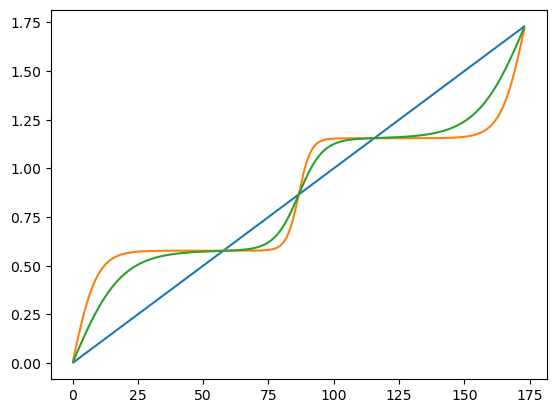

In [4]:
plt.plot(y0, dy_u)
plt.plot(y0, dy_r)
plt.plot(y0, dy_R)

In [5]:
#data for strain vs y
ody = np.ediff1d(y0)
rdy = np.ediff1d(coords_L1r[:,1])
Rdy = np.ediff1d(coords_L1R[:,1])

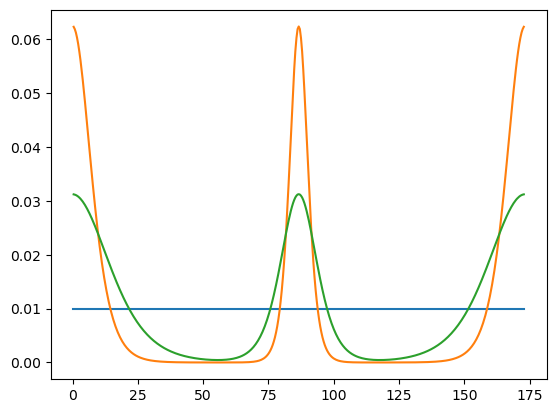

In [6]:
plt.plot([y0[0], y0[-1]], [M/N, M/N])
plt.plot((y0[1:] + y0[:-1])/2, rdy/ody -1)
print()
plt.plot((y0[1:] + y0[:-1])/2, Rdy/ody -1)

In [7]:
#data for stacking vs y
xgrid1, ygrid1, stacking1 = map_stacking(coords_L15, coords_L25, 101)
xgrid1, ygrid1, stacking2 = map_stacking(coords_L1r5, coords_L2r5, 101)
xgrid1, ygrid1, stacking3 = map_stacking(coords_L1R5, coords_L2R5, 101)

yy = ygrid1[:,0][1:-1]
p = int(ygrid1.shape[0]/2)
ss1 = (stacking1)[:, p][1:-1]
ss2 = (stacking2)[:, p][1:-1]
ss3 = (stacking3)[:, p][1:-1]

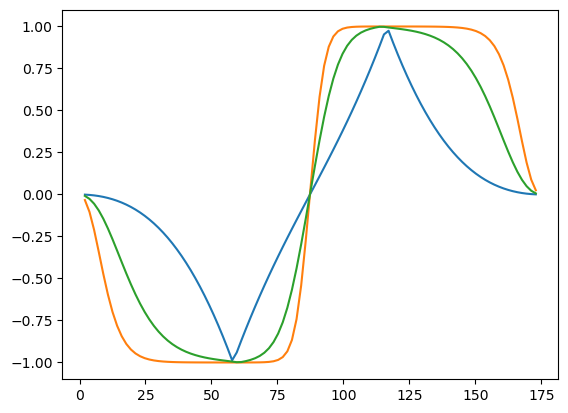

In [8]:
plt.plot(yy, ss1 )
plt.plot(yy, ss2 )
plt.plot(yy, ss3 )

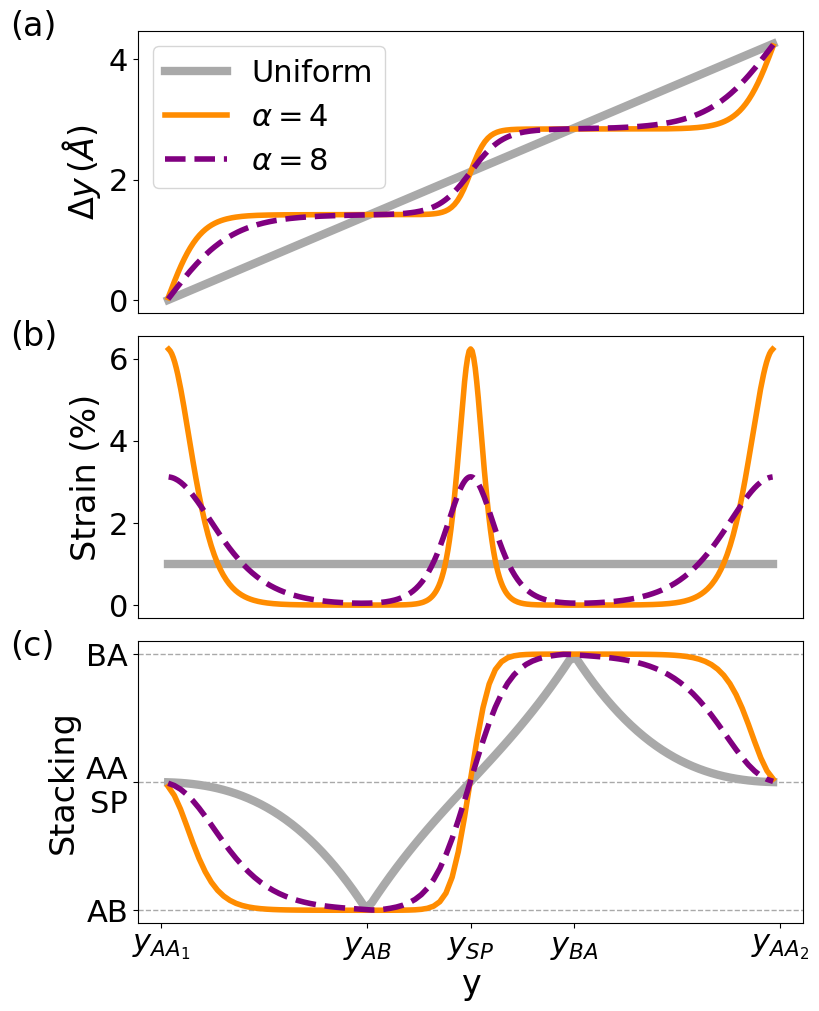

In [9]:
# composite plot

figr = plt.figure(figsize=(8, 10))

ax1 = figr.add_subplot(3,1, 1)

ax1.plot(y0*alat, dy_u*alat, color='darkgrey', linewidth=6, label='Uniform')
ax1.plot(y0*alat, dy_r*alat, color='darkorange', linewidth=4, label=r'$\alpha = 4$')
ax1.plot(y0*alat, dy_R*alat,  color='purple', linewidth=4, linestyle='--',  label=r'$\alpha = 8$')
ax1.set_ylabel(r'$\Delta y\, (\AA)$', fontsize=24)
ax1.set_xticks([])
ax1.tick_params(axis='y', which='both', labelsize=22), 
plt.legend(fontsize=22)


ax2 = figr.add_subplot(3,1, 2)
ax2.plot([y0[0]*alat, y0[-1]*alat], [100*M/N, 100*M/N], color='darkgrey', linewidth=6 )
ax2.plot( (y0[1:] + y0[:-1])*alat/2, 100*(rdy/ody -1),  color='darkorange', linewidth=4,)
ax2.plot( (y0[1:] + y0[:-1])*alat/2, 100*(Rdy/ody -1),  color='purple', linewidth=4, linestyle='--',)

ax2.set_ylabel(r'Strain (%)', fontsize=24)
ax2.set_xticks([])
ax2.tick_params(axis='y', which='both', labelsize=22)


ax3 = figr.add_subplot(3,1, 3)
ax3.plot(yy, ss1, color='darkgrey', linewidth=6, )
ax3.plot(yy, ss2, color='darkorange', linewidth=4, )
ax3.plot(yy, ss3, color='purple', linewidth=4, linestyle='--')
ax3.set_ylabel(r'Stacking', fontsize=24)
ax3.tick_params(axis='both', which='both', labelsize=22)
ax3.set_yticks([-1, 0, 1])
ax3.set_yticklabels(['AB', 'AA\nSP', 'BA'])
ax3.grid(axis = 'y',  linestyle = '--', linewidth = 1, color='darkgrey')

ax3.set_xticks([AApos1 , ABpos, SPpos, BApos, AApos2])
ax3.set_xticklabels([r'$y_{AA_1}$', r'$y_{AB}$', r'$y_{SP}$', r'$y_{BA}$', r'$y_{AA_2}$' ] )
ax3.set_xlabel(r'y', fontsize=24)

figr.text(-0.02, 0.98, '(a)', fontsize= 24)
figr.text(-0.02, 0.67, '(b)', fontsize= 24)
figr.text(-0.02, 0.36, '(c)', fontsize= 24)



plt.tight_layout()
plt.show()



In [16]:
figr.savefig('fig2_relax.pdf', bbox_inches = 'tight')

In [10]:
hams = gen_BLG_Ham_hop (coords_L1, coords_L2, M, N)

In [11]:
Kx = KK[0]
kx = np.linspace(Kx-0.18, Kx+0.18, 301)
ky = np.zeros_like(kx)


kxv = np.linspace(Kx-0.18, Kx+0.18, 31)
kyv = np.zeros_like(kxv)


In [12]:
delta = 0.0

evals = gen_BLG_BS (hams, delta, kx, ky, L1dim, L2dim)

eval2, evecs = gen_BLG_vecs (hams, delta, kxv, kyv, L1dim, L2dim)

In [13]:
projrange = 10


AAsites1 = np.where( (coords_L1[:,1] < AApos1+projrange) | (coords_L1[:,1] > AApos2-projrange) )[0]
AAsites2 = np.array(np.where((coords_L2[:,1] < AApos1+projrange) | (coords_L2[:,1] > AApos2-projrange))[0]) + L1dim

ABsites1 = np.where( (coords_L1[:,1] > ABpos-projrange) & (coords_L1[:,1] < ABpos+projrange) )[0]
ABsites2 = np.array(np.where( (coords_L2[:,1] > ABpos-projrange) & (coords_L2[:,1] < ABpos+projrange) )[0]) + L1dim

BAsites1 = np.where( (coords_L1[:,1] > BApos-projrange) & (coords_L1[:,1] < BApos+projrange) )[0]
BAsites2 = np.array(np.where( (coords_L2[:,1] > BApos-projrange) & (coords_L2[:,1] < BApos+projrange) )[0]) + L1dim

SPsites1 = np.where( (coords_L1[:,1] > SPpos-projrange) & (coords_L1[:,1] < SPpos+projrange) )[0]
SPsites2 = np.array(np.where( (coords_L2[:,1] > SPpos-projrange) & (coords_L2[:,1] < SPpos+projrange) )[0]) + L1dim



AAsites = np.concatenate((AAsites1, AAsites2))
ABsites = np.concatenate((ABsites1, ABsites2))
BAsites = np.concatenate((BAsites1, BAsites2))
SPsites = np.concatenate((SPsites1, SPsites2))


In [15]:
AAproj = (np.abs(evecs[:, AAsites, :])**2).sum(axis=1).T
ABproj = (np.abs(evecs[:, ABsites, :])**2).sum(axis=1).T
BAproj = (np.abs(evecs[:, BAsites, :])**2).sum(axis=1).T
SPproj = (np.abs(evecs[:, SPsites, :])**2).sum(axis=1).T



ev2 = eval2.T

In [16]:
pts2d=91
kx2b = np.linspace(KK[0]-0.45, KK[0]+0.45, pts2d)
ky2b = np.linspace(KK[1]-0.45, KK[1]+0.45, pts2d)

kx2, ky2 = np.meshgrid(kx2b, ky2b)

#rint(kx2.shape)

ev3AA = BLG_bands (kx2, ky2, AAx, AAy, delta)
ev3AB = BLG_bands (kx2, ky2, ABx, ABy, delta)
ev3SP = BLG_bands (kx2, ky2, intxa, intya, delta)

evAA = BLG_bands (kx, KK[1]*np.ones_like(kx), AAx, AAy, delta)
evAB = BLG_bands (kx, KK[1]*np.ones_like(kx), ABx, ABy, delta)
evSP = BLG_bands (kx, KK[1]*np.ones_like(kx), intxa, intya, delta)




In [17]:
def get_dos(erange, evals, b=0.1):
    er, ev = np.meshgrid(erange, evals)
    dosc = lorentzian(er, ev, b) 
    return dosc.sum(axis=0)/len(evals)

In [18]:
derange = np.linspace(-0.6, 0.6, 121)
derange.shape

(121,)

In [19]:
AAdos = []

for ttt in np.arange(len(ev3AA)):
    tempdos = get_dos(derange, ev3AA[:, ttt, :].flatten(), b=0.05)
    AAdos.append(tempdos)

AAdos = np.array(AAdos).T
    
ABdos = []

for ttt in np.arange(len(ev3AB)):
    tempdos = get_dos(derange, ev3AB[:, ttt, :].flatten(), b=0.05)
    ABdos.append(tempdos)
    
ABdos = np.array(ABdos).T

SPdos = []

for ttt in np.arange(len(ev3SP)):
    tempdos = get_dos(derange, ev3SP[:, ttt, :].flatten(), b=0.05)
    SPdos.append(tempdos)
    
SPdos = np.array(SPdos).T

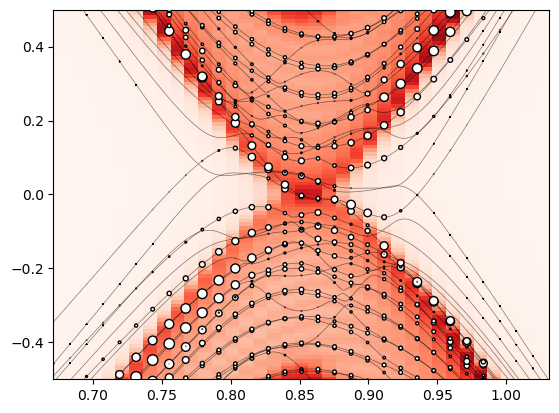

In [20]:
ktt, ett = np.meshgrid(kx2b, derange)
plt.pcolormesh(ktt, ett, ABdos, cmap='Reds',  shading='auto' )

plt.plot(kx, evals, 'k-', lw=0.5, zorder=2, alpha=0.5)


for n, e in enumerate(ev2):
    plt.scatter(kxv, e, s = 500*np.abs(ABproj[n])**2, c='k', zorder=3, rasterized=True, fc='white', ec='k')
    
plt.gca().set_ylim(-0.5, 0.5)
plt.gca().set_xlim(Kx-0.18, Kx+0.18)
        
plt.show()

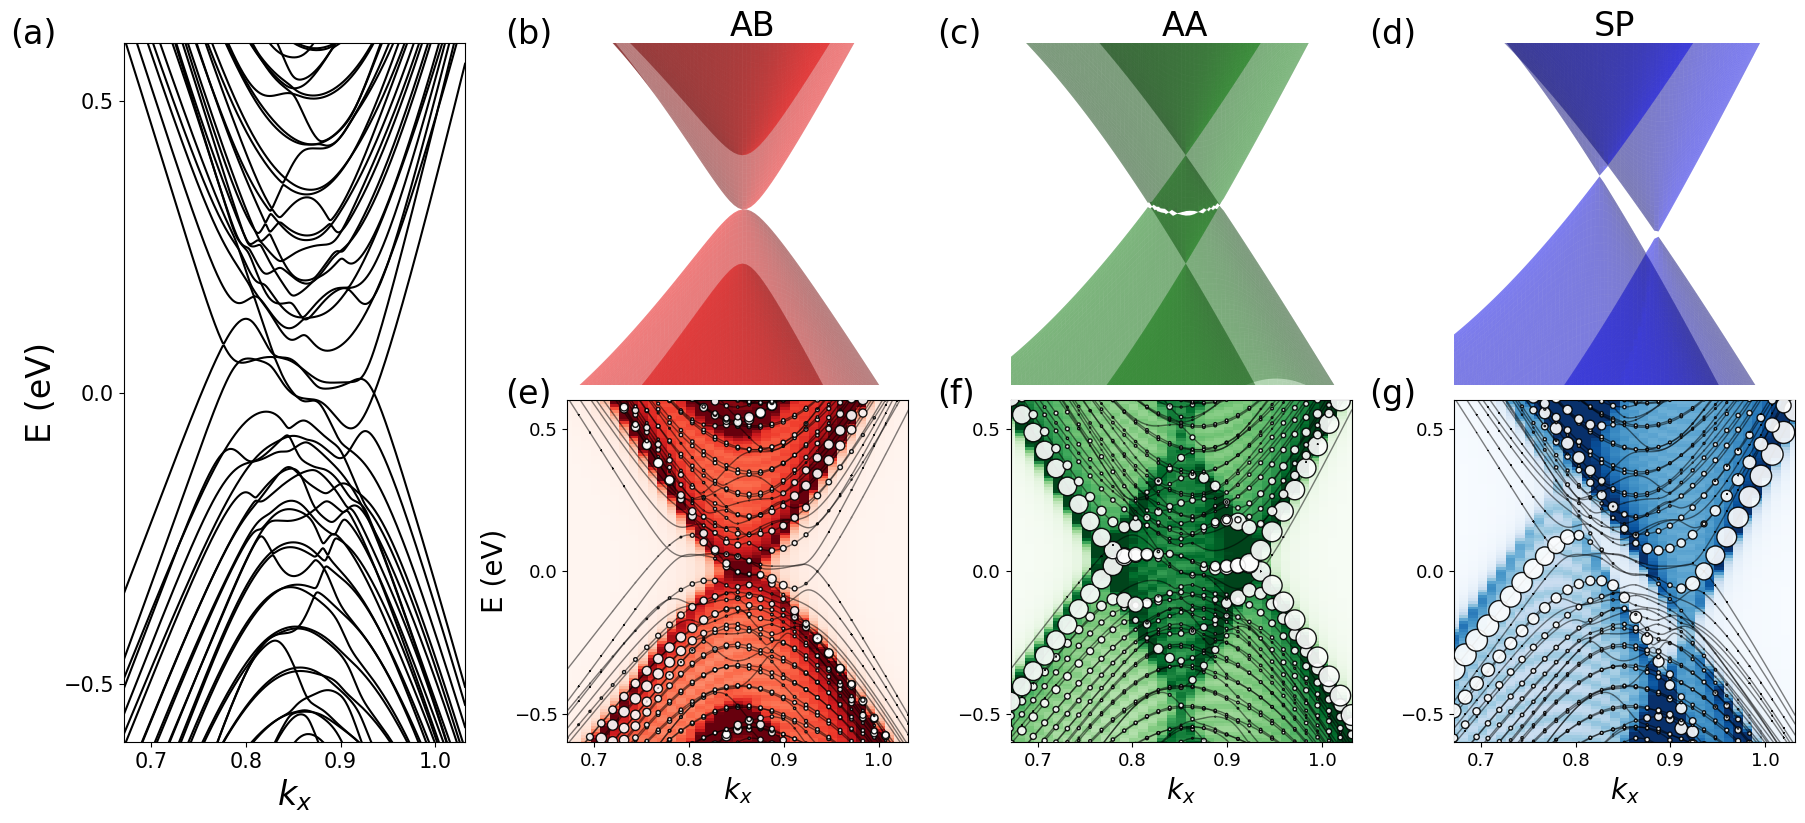

In [21]:
fig3 = plt.figure(figsize=(18, 8))

ax = fig3.add_subplot(1,4, 1)

ax.plot(kx, evals, 'k-', ms=1)
ax.set_ylim(-0.6, 0.6)
ax.set_xlim(Kx-0.18, Kx+0.18)

ax.set_ylabel('E (eV)', fontsize=24)
ax.set_yticks([-0.5, 0, 0.5])
ax.tick_params(axis='both', which='both', labelsize=15)

ax.set_xlabel(r'$k_x$', fontsize=24)

facs=[500, 300, 300]

fig3.text(0.0, 0.98, '(a)', fontsize= 24)

c=['red', 'green', 'blue']
panel=0

pan_labs=['(b)', '(c)', '(d)']

for ev in [ev3AB, ev3AA, ev3SP]:
    ax = fig3.add_subplot(2,4, panel+2, projection='3d')

    
    for i in range(4):
        ax.plot_surface(kx2, ky2, ev[:,:,i], alpha = 0.3, color = c[panel], 
                   edgecolor='None', antialiased=True, linewidth=0.2, cstride=1, rstride=1, rasterized=True)
    fig3.text(0.275+0.24*panel, 0.98,  pan_labs[panel], fontsize= 24)

    
    ax.axes.set_zlim3d(-0.7, 0.7)
    ax.view_init(elev=0, azim=-90)

    ax.set_xlim(Kx-0.25, Kx+0.25)
    ax.set_ylim(KK[1]-0.25, KK[1]+0.25)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.line.set_linewidth(0)
    ax.yaxis.line.set_linewidth(0)
    ax.zaxis.line.set_linewidth(0)
    ax.set_axis_off()
    


    panel+=1
       

pan_labs2=['(e)', '(f)', '(g)']
cmaps=['Reds', 'Greens', 'Blues']

panel=0
for ev, proj in zip( [ABdos, AAdos, SPdos], [ABproj, AAproj, SPproj]) :
    
    
        
    ax = fig3.add_subplot(2,4, panel+6)
    ax.plot(kx, evals, 'k-', lw=1, zorder=2, alpha=0.5)
    ax.set_ylim(-0.6, 0.6)
    ax.set_xlim(Kx-0.18, Kx+0.18)
    
    for n, e in enumerate(ev2):
        plt.scatter(kxv, e, s = facs[panel]*np.abs(proj[n])**2,  zorder=3, rasterized=True, 
                   c='k', fc='white', ec='k', alpha=0.9)
    
    fig3.text(0.275+0.24*panel, 0.53,  pan_labs2[panel], fontsize= 24)
    ax.pcolormesh(ktt, ett, ev, cmap=cmaps[panel],  shading='auto', vmin=0.005, vmax=0.25, rasterized=True )

    
    ax.tick_params(axis='both', which='both', labelsize=13)
    ax.set_yticks([-0.5, 0, 0.5])
    
    if panel == 0:
        ax.set_ylabel('E (eV)', fontsize=20)
        
    ax.set_xlabel(r'$k_x$', fontsize=20)

    
    panel+=1
    
    
fig3.text(0.4, 0.99,  'AB', fontsize= 24)
fig3.text(0.64, 0.99,  'AA', fontsize= 24)
fig3.text(0.88, 0.99,  'SP', fontsize= 24)


    
plt.tight_layout()
plt.show()

In [22]:
fig3.savefig('fig2_bands.pdf', bbox_inches = 'tight')